In [87]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [88]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

In [89]:
chars = sorted(list(set(''.join(words))))
chars.insert(0, ".")
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [90]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])            # 80% split
Xdev, Ydev = build_dataset(words[n1:n2])        # 10% split
Xte, Yte = build_dataset(words[n2:])            # 10% split


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Initialization

At our first initialization, the model had fake confidence at some nodes due to high initial logits.
These cause the model to have fake confidence to certain letters. 
We took care of this by initializing the bias to zero and multiplying the weights with a small value.

In our first layer of the neural net we have the problem that the hyperbolic tangent of our first layer (the activation function) would give lots of -1 and 1 values due to large numbers.
Another way to describe this problem is to say that our activation function is very "active" since it has to squash down many numbers.

A dead ReLU neuron can occur with too large of a gradient.
Flat parts in your activation function can cause a neuron to fall off.

Most people now initialize with kaiming_normal.
Kaiming_normal has a scaling factor and a gain factor.
The gain factor is in place to renormalize everything to unit normal.

These modern innovations have made it less important to initialize your neural nets.
- Residual connections
- Multiple normalization layers
- Better optimizers

In [95]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),     generator=g)  * ((5/3) / (n_embd * block_size) ** 0.50)
# b1 = torch.randn(n_hidden,                          generator=g)    * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g)    * 0.01     # by making our weight smaller we ensure that the model starts without fake confidence
b2 = torch.randn(vocab_size,                        generator=g)    * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))



parameters = [C, W1, W2, b2, bngain, bnbias]
print("Total number of parameters : ", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


Total number of parameters :  12097


In [96]:
# Parameters for training
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.reshape(emb.shape[0], -1)  # concatenate the vectors of the characters
    hpreact = embcat @ W1 #+ b1             # hidden layer pre-activation
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    loss = F.cross_entropy(logits, Yb)      # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 1e5 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [65]:
hpreact.mean(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [66]:
h.shape

torch.Size([32, 200])

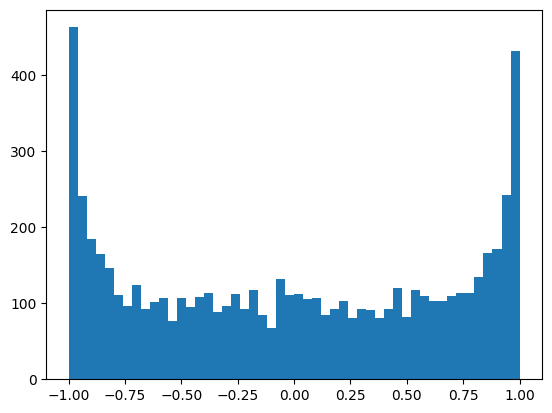

In [81]:
plt.hist(h.view(-1).tolist(), 50);

During our backprop we start at the loss and flow backward through our network.
If we backpropagate through a tanh, a value of one or minus one wil lead to a zero gradient. Therefore it will no longer change.
The weights and biases along with this neuron will no longer affect the loss (the tails are flat).

The tanh does only decrease your gradient. If all of the outputs of h are in -1 and 1, the gradients of these will be destroyed in the optimization.

If all your outputs of h are -1 or 1, then the whole neuron is basically off. The neuron will then never learn.

Remember that initializing your network in a good manner and checking if all the neurons are setup fresh plus a loss function of complete randomness is found, this can significantly affect the results you find after training."
We basically spend more time at productive training.

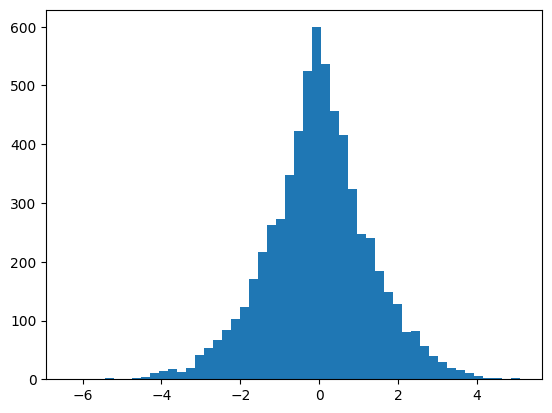

In [82]:
plt.hist(hpreact.view(-1).tolist(), 50);


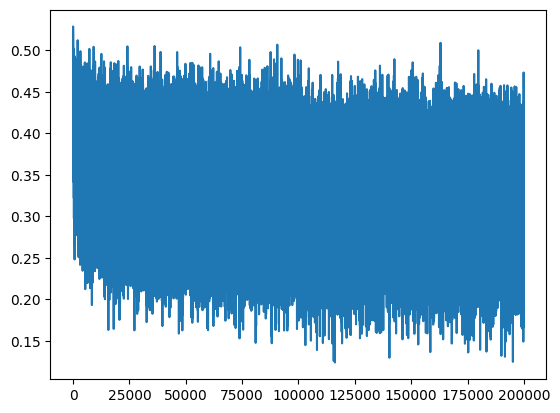

In [83]:
plt.plot(lossi)

In [97]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # Measures the mean and std over the entire training set as fixed numbers you can use.
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [98]:
@torch.no_grad()  # A decorator that disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.reshape(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1              # hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running) + bnbias
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056840419769287


In [102]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

briahgmnazzierstel.
fhal.
qetvangendra.
zasderidgmlillshi.
jedrekesslangfarremyahmilkarib.
shdumrithghnestin.
jewtdvi.
xibuscfsubferndersymusemels.
kaylahshmyah.
haz.
sadya.
sufizajahkirrentirbbisvekostep.
qwilfeyroshbh.
zprixabumushwa.
hmarishid.
qinfelvshlwaldarikthrishthzighikassmitgftrvissivishten.
riefhrriyaxabushdumichekitya.
blvardtai.
bdgihzirrlq.
saadenaysophlrystta.


# P2: Building a deeper net

To build a deeper network we will torchify our code to speak by creating different modules.

This would make it much easier to construct our network much like we do in pytorch


In [108]:
# Torchifying our code :)

class Linear:

    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.50
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is not None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backpropegation)
        self.gamma = torch.ones(dim)    # these are Actual trainable params   
        self.beta = torch.zeros(dim)    # these are Actual trainable params
        # buffers (update the running mean of the total to keep model applicable to single examples instead of batches)
        self.running_var = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True) # batch mean
            xvar = x.var(dim=0, keepdim=True)   # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum) * xmean
                self.running_var = (1 - self.momentum) * self.running_var + (self.momentum) * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [113]:
n_embd = 10 # dim of embedding of the character vectors
n_hidden = 100 # the number of neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers =[
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [111]:
# Parameters for training
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.reshape(emb.shape[0], -1)  # concatenate the vectors of the characters
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 1e5 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break


      0/ 200000: 3.2962
